In [2]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [3]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [4]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Howard_TheDevilinIron',
 'Poe_EurekaAProsePoem',
 'Doyle_AScandalinBohemia',
 'Poe_TheCaskofAmontillado',
 'Kipling_ThyServantaDog']

#### Corpus laden

In [5]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [6]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [7]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [9]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [10]:
sparse_bow[:5]

0
doc_id token_id    
1      14239      1
       5          1
       6274       1
       16391     10
       9          1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [11]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [12]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [13]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [14]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [15]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [16]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Finding hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [42]:
doc_labels = ['exampletext1', 'exampletext2']
doc_tokens = [['test', 'corpus'], ['for', 'testing']]
type_dictionary = {'test': 1, 'corpus': 2, 'for': 3, 'testing': 4}
doc_dictionary = {'exampletext1': 1, 'exampletext2': 2}
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, type_dictionary, doc_dictionary)
from gensim.models import LdaModel
from gensim.corpora import Dictionary
corpus = [['test', 'corpus'], ['for', 'testing']]
dictionary = Dictionary(corpus)
documents = [dictionary.doc2bow(document) for document in corpus]
model = LdaModel(corpus=documents, id2word=dictionary, iterations=1, passes=1, num_topics=1)
l = pre.make_doc2bow_list(sparse_bow)
x = pre.make_doc_topic_matrix(model, l, )

INFO gensim.corpora.dictionary: adding document #0 to Dictionary(0 unique tokens: [])
INFO gensim.corpora.dictionary: built Dictionary(4 unique tokens: ['testing', 'test', 'corpus', 'for']) from 2 documents (total 4 corpus positions)
INFO gensim.models.ldamodel: using symmetric alpha at 1.0
INFO gensim.models.ldamodel: using symmetric eta at 0.25
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 1 topics, 1 passes over the supplied corpus of 2 documents, updating model once every 2 documents, evaluating perplexity every 2 documents, iterating 1x with a convergence threshold of 0.001000
WARNING gensim.models.ldamodel: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO gensim.models.ldamodel: -1.684 per-word bound, 3.2 perplexity estimate based on a held-out corpus of 2 documents with 4 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, a

In [43]:
l

[[(1, 1), (2, 1)], [(3, 1), (4, 1)]]

In [17]:
len(features_to_be_removed)

75

In [18]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [19]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 192053 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [20]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [21]:
len(doc2bow_list)

17

In [22]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 10 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 20x with a convergence threshold of 0.001000
INFO gensim.models.ldamodel: -14.378 per-word bound, 21290.7 perplexity estimate based on a held-out corpus of 17 documents with 192053 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #10 (0.050): 0.003*"implore" + 0.003*"skins" + 0.003*"rubbish-removal" + 0.003*"jumped-up" + 0.003*"up-to" + 0.003*"bedtime" + 0.003*"formations" + 0.003*"squires" + 0.003*"episode" + 0.003*"exists"
INFO gensim.models.ldamodel: topic #12 (0.050): 0.003*"intermittently" + 0.003*"clubbed" + 0.003*"dev

INFO gensim.models.ldamodel: topic #7 (0.050): 0.004*"dim-lit" + 0.003*"dust-binning" + 0.003*"deviate" + 0.003*"mud-colored" + 0.003*"patchwork" + 0.003*"wolflike" + 0.003*"bacon-engendered" + 0.003*"clubbed" + 0.002*"prosecute" + 0.002*"storm"
INFO gensim.models.ldamodel: topic #14 (0.050): 0.002*"telling" + 0.001*"herein" + 0.001*"storm" + 0.001*"poisonously" + 0.001*"rubbish-removal" + 0.001*"clubbed" + 0.001*"intermittently" + 0.001*"squires" + 0.001*"fulsome" + 0.001*"formations"
INFO gensim.models.ldamodel: topic #3 (0.050): 0.001*"portsmouth" + 0.001*"implore" + 0.001*"poisonously" + 0.001*"jumped-up" + 0.001*"intermittently" + 0.001*"up-to" + 0.001*"episode" + 0.001*"nevada" + 0.001*"dim-lit" + 0.001*"herein"
INFO gensim.models.ldamodel: topic #0 (0.050): 0.004*"tchk" + 0.003*"saurian" + 0.002*"reflectively" + 0.002*"finance" + 0.002*"unlike" + 0.002*"advising" + 0.002*"rock-strewn" + 0.002*"bombay" + 0.002*"burned" + 0.002*"abundance"
INFO gensim.models.ldamodel: topic diff=0

In [25]:
doc2bow_list[0]

[(14239, 1),
 (5, 1),
 (6274, 1),
 (16391, 10),
 (9, 1),
 (16394, 1),
 (9559, 13),
 (14, 1),
 (8209, 16),
 (8210, 3),
 (16405, 4),
 (9561, 1),
 (24, 2),
 (16409, 1),
 (27, 1),
 (28, 4),
 (29, 1),
 (16414, 1),
 (8197, 2),
 (16416, 1),
 (33, 1),
 (34, 4),
 (8227, 5),
 (16424, 1),
 (16425, 1),
 (8235, 1),
 (45, 7),
 (46, 2),
 (48, 1),
 (49, 5),
 (50, 1),
 (51, 1),
 (53, 1),
 (8247, 47),
 (8248, 10),
 (16441, 1),
 (8250, 24),
 (9567, 1),
 (8252, 8),
 (16446, 40),
 (64, 2),
 (67, 1),
 (16455, 19),
 (74, 6),
 (79, 6),
 (8272, 22),
 (82, 1),
 (8393, 1),
 (16470, 5),
 (8279, 2),
 (5476, 6),
 (16475, 4),
 (8284, 1),
 (16479, 2),
 (10939, 15),
 (8294, 1),
 (106, 1),
 (8301, 1),
 (110, 1),
 (16497, 1),
 (15825, 1),
 (8308, 1),
 (16501, 5),
 (8311, 39),
 (16504, 1),
 (16505, 3),
 (16511, 62),
 (128, 3),
 (1387, 21),
 (16517, 5),
 (8326, 1),
 (16521, 1),
 (16522, 2),
 (144, 2),
 (19645, 1),
 (8339, 1),
 (148, 2),
 (8341, 11),
 (8342, 1),
 (1391, 5),
 (156, 2),
 (8349, 1),
 (159, 1),
 (16544, 1),
 (

In [26]:
model.get_document_topics(doc2bow_list[0])

[(1, 0.011065446524044171),
 (2, 0.03616972607010803),
 (4, 0.23327295293704223),
 (6, 0.080304139069213451),
 (7, 0.025600459983587325),
 (9, 0.1391795035312435),
 (10, 0.13700385368060766),
 (11, 0.031787996739696657),
 (13, 0.08616917820398512),
 (15, 0.17351389748419174),
 (18, 0.036160735815802932)]

In [28]:
#Anzeige der keywords für topic n
n = 2
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['ravenous',
 'master-an',
 'mechanism',
 'dinner',
 'eight',
 'implore',
 'six-foot',
 'shores',
 'clubbed',
 'style']

In [24]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic in topics:
    idx = topic[0]
    temp = topic[1]
    topics_df.loc[idx] = temp
        
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(tenable, 0.0256763502322)","(effort, 0.0224644940558)","(creak, 0.0202541531196)","(conform, 0.0126477548353)","(rat-tat, 0.0122980209997)","(hisself, 0.00545681404758)","(ead, 0.00397332708108)","(porcupine, 0.00393325415662)","(constructed, 0.00381602711294)","(dusk, 0.00312505253715)"
1,"(bathroom, 0.000292656679459)","(rose, 0.000263192563722)","(because, 0.000253779441558)","(connectives, 0.000249067825705)","(special, 0.000239556380904)","(overgrown, 0.000238818751653)","(cch, 0.000237201043438)","(hoicked, 0.000235305950815)","(reconnoitering, 0.000233619653851)","(scoundrels, 0.00023220902298)"
2,"(effort, 0.00477874453846)","(tenable, 0.00189935043311)","(supercharged, 0.00170935575759)","(unbelievable, 0.00124348802233)","(dusk, 0.00116769771071)","(ding-dong, 0.000957642774614)","(unpleasantly, 0.000870229370073)","(brightly, 0.000844208719608)","(house, 0.000833223213178)","(toast, 0.000798263083577)"
3,"(rose, 0.000274796916015)","(prim-faced, 0.000270057969491)","(lecture, 0.000267001971257)","(pithy, 0.000250911565034)","(branding, 0.000246215116032)","(spaniel, 0.000245328286977)","(flipperling, 0.000235923287778)","(connectives, 0.000233947570793)","(gaslight, 0.0002323363494)","(overgrown, 0.000227666775726)"
4,"(bathroom, 0.000296820550557)","(branding, 0.000280163196338)","(overgrown, 0.000272939388234)","(because, 0.000250809069747)","(bartholomew, 0.000247923773065)","(scoundrels, 0.000245513225449)","(pithy, 0.00024292609)","(porous, 0.000241706324266)","(modifications, 0.000241684690564)","(rose, 0.000238904697706)"
5,"(unbelievable, 0.0134244044146)","(effort, 0.0104293304222)","(tenable, 0.00650449495352)","(brightly, 0.00494234787732)","(villagers, 0.00365858723915)","(horns, 0.00337981481887)","(toast, 0.00300755757947)","(singular, 0.00286635270794)","(of-things, 0.00262951830358)","(saddest, 0.0024920130101)"
6,"(horns, 0.0586539786326)","(conform, 0.0373058334589)","(constructed, 0.0253806063999)","(creak, 0.0189527379091)","(effort, 0.0176734000054)","(unpleasantly, 0.012710269741)","(rat-tat, 0.0121167108002)","(troubles, 0.011075357809)","(hints, 0.0103458601442)","(dusk, 0.0099186053893)"
7,"(overgrown, 0.000302720304746)","(pithy, 0.000289116358814)","(reçue, 0.000284153364941)","(cch, 0.000277006172989)","(because, 0.000251956329793)","(connectives, 0.000250860123592)","(lecture, 0.000250442417446)","(tiger-skins, 0.000245909795221)","(modifications, 0.000233970317764)","(hotly, 0.000229568750916)"
8,"(climates, 0.0439846680571)","(wooden-roofed, 0.0347351368792)","(effort, 0.03245597571)","(neglect, 0.0253794853262)","(hisself, 0.0229490464767)","(unbelievable, 0.01493422843)","(foxhound, 0.00987676515313)","(processions, 0.0089539222511)","(screened, 0.00724280069163)","(affrightedly, 0.00705989392268)"
9,"(long-standing, 0.00029084250426)","(pithy, 0.000255305518771)","(scoundrels, 0.000253619630244)","(because, 0.000242324958932)","(reçue, 0.000240472271349)","(bathroom, 0.000235131928592)","(reconnoitering, 0.000234105569072)","(tiger-skins, 0.000230784590525)","(enclose, 0.000230241911718)","(connectives, 0.000229019829322)"


In [25]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(tenable, 0.0256763502322)","(effort, 0.0224644940558)","(creak, 0.0202541531196)","(conform, 0.0126477548353)","(rat-tat, 0.0122980209997)","(hisself, 0.00545681404758)","(ead, 0.00397332708108)","(porcupine, 0.00393325415662)","(constructed, 0.00381602711294)","(dusk, 0.00312505253715)"
1,"(bathroom, 0.000292656679459)","(rose, 0.000263192563722)","(because, 0.000253779441558)","(connectives, 0.000249067825705)","(special, 0.000239556380904)","(overgrown, 0.000238818751653)","(cch, 0.000237201043438)","(hoicked, 0.000235305950815)","(reconnoitering, 0.000233619653851)","(scoundrels, 0.00023220902298)"
2,"(effort, 0.00477874453846)","(tenable, 0.00189935043311)","(supercharged, 0.00170935575759)","(unbelievable, 0.00124348802233)","(dusk, 0.00116769771071)","(ding-dong, 0.000957642774614)","(unpleasantly, 0.000870229370073)","(brightly, 0.000844208719608)","(house, 0.000833223213178)","(toast, 0.000798263083577)"
3,"(rose, 0.000274796916015)","(prim-faced, 0.000270057969491)","(lecture, 0.000267001971257)","(pithy, 0.000250911565034)","(branding, 0.000246215116032)","(spaniel, 0.000245328286977)","(flipperling, 0.000235923287778)","(connectives, 0.000233947570793)","(gaslight, 0.0002323363494)","(overgrown, 0.000227666775726)"
4,"(bathroom, 0.000296820550557)","(branding, 0.000280163196338)","(overgrown, 0.000272939388234)","(because, 0.000250809069747)","(bartholomew, 0.000247923773065)","(scoundrels, 0.000245513225449)","(pithy, 0.00024292609)","(porous, 0.000241706324266)","(modifications, 0.000241684690564)","(rose, 0.000238904697706)"
5,"(unbelievable, 0.0134244044146)","(effort, 0.0104293304222)","(tenable, 0.00650449495352)","(brightly, 0.00494234787732)","(villagers, 0.00365858723915)","(horns, 0.00337981481887)","(toast, 0.00300755757947)","(singular, 0.00286635270794)","(of-things, 0.00262951830358)","(saddest, 0.0024920130101)"
6,"(horns, 0.0586539786326)","(conform, 0.0373058334589)","(constructed, 0.0253806063999)","(creak, 0.0189527379091)","(effort, 0.0176734000054)","(unpleasantly, 0.012710269741)","(rat-tat, 0.0121167108002)","(troubles, 0.011075357809)","(hints, 0.0103458601442)","(dusk, 0.0099186053893)"
7,"(overgrown, 0.000302720304746)","(pithy, 0.000289116358814)","(reçue, 0.000284153364941)","(cch, 0.000277006172989)","(because, 0.000251956329793)","(connectives, 0.000250860123592)","(lecture, 0.000250442417446)","(tiger-skins, 0.000245909795221)","(modifications, 0.000233970317764)","(hotly, 0.000229568750916)"
8,"(climates, 0.0439846680571)","(wooden-roofed, 0.0347351368792)","(effort, 0.03245597571)","(neglect, 0.0253794853262)","(hisself, 0.0229490464767)","(unbelievable, 0.01493422843)","(foxhound, 0.00987676515313)","(processions, 0.0089539222511)","(screened, 0.00724280069163)","(affrightedly, 0.00705989392268)"
9,"(long-standing, 0.00029084250426)","(pithy, 0.000255305518771)","(scoundrels, 0.000253619630244)","(because, 0.000242324958932)","(reçue, 0.000240472271349)","(bathroom, 0.000235131928592)","(reconnoitering, 0.000234105569072)","(tiger-skins, 0.000230784590525)","(enclose, 0.000230241911718)","(connectives, 0.000229019829322)"


In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(tenable, 0.0256763502322)","(bathroom, 0.000292656679459)","(effort, 0.00477874453846)","(rose, 0.000274796916015)","(bathroom, 0.000296820550557)","(unbelievable, 0.0134244044146)","(horns, 0.0586539786326)","(overgrown, 0.000302720304746)","(climates, 0.0439846680571)","(long-standing, 0.00029084250426)","(cch, 0.000311747618806)","(overgrown, 0.000277225489952)","(effort, 0.075334045705)","(lecture, 0.000243784641922)","(cch, 0.000250955265681)","(effort, 0.0661360961594)","(effort, 0.0566209508089)","(branding, 0.0002956870851)","(effort, 0.00184400826251)","(effort, 0.0659661802756)"
1,"(effort, 0.0224644940558)","(rose, 0.000263192563722)","(tenable, 0.00189935043311)","(prim-faced, 0.000270057969491)","(branding, 0.000280163196338)","(effort, 0.0104293304222)","(conform, 0.0373058334589)","(pithy, 0.000289116358814)","(wooden-roofed, 0.0347351368792)","(pithy, 0.000255305518771)","(lecture, 0.000282898202994)","(pithy, 0.000260994618144)","(unbelievable, 0.0644336008462)","(bartholomew, 0.000238651814401)","(because, 0.000232228697326)","(unpleasantly, 0.0429527275233)","(creak, 0.0377583131185)","(pithy, 0.000294020396584)","(creak, 0.00120105373513)","(unbelievable, 0.0640919887144)"
2,"(creak, 0.0202541531196)","(because, 0.000253779441558)","(supercharged, 0.00170935575759)","(lecture, 0.000267001971257)","(overgrown, 0.000272939388234)","(tenable, 0.00650449495352)","(constructed, 0.0253806063999)","(reçue, 0.000284153364941)","(effort, 0.03245597571)","(scoundrels, 0.000253619630244)","(prim-faced, 0.000261976458957)","(prim-faced, 0.000244163639586)","(tenable, 0.0269811351657)","(because, 0.00023519956112)","(tiger-skins, 0.000231397456649)","(creak, 0.0397260473325)","(unbelievable, 0.0269642652559)","(spaniel, 0.000286429729128)","(of-things, 0.000783725048712)","(creak, 0.0298918465505)"
3,"(conform, 0.0126477548353)","(connectives, 0.000249067825705)","(unbelievable, 0.00124348802233)","(pithy, 0.000250911565034)","(because, 0.000250809069747)","(brightly, 0.00494234787732)","(creak, 0.0189527379091)","(cch, 0.000277006172989)","(neglect, 0.0253794853262)","(because, 0.000242324958932)","(tiger-skins, 0.000258612947765)","(tiger-skins, 0.000235186374615)","(unpleasantly, 0.020703794657)","(branding, 0.000228188691535)","(lecture, 0.000231313739582)","(wonderful, 0.0272530070208)","(conform, 0.0217086059383)","(bartholomew, 0.000271184145851)","(singular, 0.00055410196059)","(tenable, 0.0218768925397)"
4,"(rat-tat, 0.0122980209997)","(special, 0.000239556380904)","(dusk, 0.00116769771071)","(branding, 0.000246215116032)","(bartholomew, 0.000247923773065)","(villagers, 0.00365858723915)","(effort, 0.0176734000054)","(because, 0.000251956329793)","(hisself, 0.0229490464767)","(reçue, 0.000240472271349)","(branding, 0.000255888783283)","(connectives, 0.000230838868141)","(conform, 0.0204121180294)","(special, 0.000223494969839)","(appeased, 0.000229327050465)","(dusk, 0.0221691883238)","(villagers, 0.0214856019305)","(hoicked, 0.000269551462172)","(villagers, 0.000531494369313)","(villagers, 0.0202063016417)"
5,"(hisself, 0.00545681404758)","(overgrown, 0.000238818751653)","(ding-dong, 0.000957642774614)","(spaniel, 0.000245328286977)","(scoundrels, 0.000245513225449)","(horns, 0.00337981481887)","(unpleasantly, 0.012710269741)","(connectives, 0.000250860123592)","(unbelievable, 0.01493422843)","(bathroom, 0.000235131928592)","(bathroom, 0.000244414685256)","(watchmen, 0.000230175570302)","(misty, 0.0152481662556)","(bathroom, 0.000221530641515)","(special, 0.000220078777605)","(hisself, 0.0150463922352)","(dusk, 0.0209633085072)","(tiger-skins, 0.000268386996971)","(toast, 0.000504095498573)","(house, 0.0194565443557)"
6,"(ead, 0.00397332708108)","(cch, 0.000237201043438)","(unpleasantly, 0.000870229370073)","(flipperling, 0.000235923287778)","(pithy, 0.00024292609)","(toast, 0.00300755757947)","(rat-tat, 0.0121167108002)","(lecture, 0.000250442417446)","(f

## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

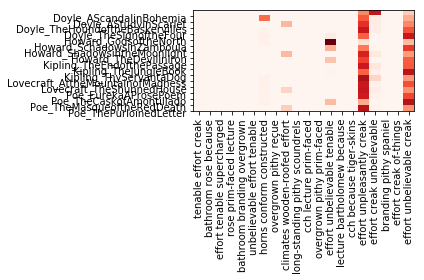

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

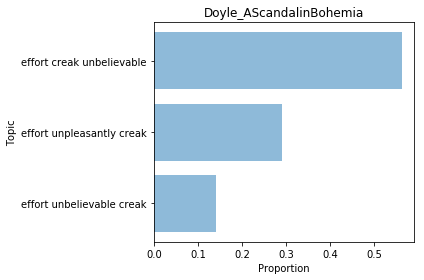

In [30]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)